## Importing the libraries and reading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
df = pd.read_csv("reviews.csv")
df.head()

,reviews.rating,reviews.text
0,1,This product so far has not disappointed. My c...
1,1,great for beginner or experienced person. Boug...
2,1,Inexpensive tablet for him to use and learn on...
3,1,I've had my Fire HD 8 two weeks now and I love...
4,1,I bought this for my grand daughter when she c...


So, we have 2 columns 
* Rating column
* Text column

We are required to build a Naive Bayes Classifier to predict the rating ("polarity detection")

Before getting into building the model, let's explore the data, and clean it

## Data Cleaning

#### Let's rename the columns to be prettier

In [3]:
df.rename(columns={"reviews.rating":"rating", "reviews.text":"text"}, inplace = True)
df.head()

,rating,text
0,1,This product so far has not disappointed. My c...
1,1,great for beginner or experienced person. Boug...
2,1,Inexpensive tablet for him to use and learn on...
3,1,I've had my Fire HD 8 two weeks now and I love...
4,1,I bought this for my grand daughter when she c...


#### Check for nulls or duplicates

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34659 entries, 0 to 34658
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  34659 non-null  int64 
 1   text    34659 non-null  object
dtypes: int64(1), object(1)
memory usage: 541.7+ KB


So, the rating is read as int correctly, and there are no null values

In [5]:
df.duplicated().any()

False

#### Check the values in the rating column

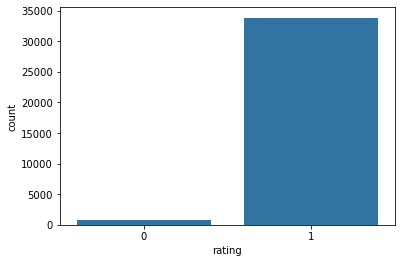

In [6]:
sb.countplot(data = df, x = "rating", color = sb.color_palette()[0]);

In [7]:
df.rating.value_counts()

1    33847
0      812
Name: rating, dtype: int64

So, the data is **very unbalanced**. For that, the accuracy score is not enough.

## Model building and Training

## Iteration 1

### Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
Y = df.rating
X = df.text

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

### Bag of words and vectorization

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
vectorizer = CountVectorizer()
X_train_mat = vectorizer.fit_transform(X_train)
vectorizer.get_feature_names()[:10]

['00', '000', '000s', '01', '04', '05', '06', '10', '100', '1000']

So, it looks there are lots of numeric things, which are not important. I will feed the vectorizer with a regex expression for the token to **discard any that contains numbers, and keeps only words that are at least 3 characters long**

In [13]:
vectorizer = CountVectorizer(token_pattern=r"\b[^\d\W]{3,}\b") 
X_train_mat = vectorizer.fit_transform(X_train)
vectorizer.get_feature_names()[:10]

['_____',
 '_without_',
 'aaa',
 'aamazon',
 'aand',
 'abandon',
 'abandoning',
 'abc',
 'abcmouse',
 'abcs']

### Building Naive Bayes model

In [14]:
from sklearn.naive_bayes import MultinomialNB

In [15]:
naive_model = MultinomialNB()
naive_model.fit(X_train_mat, Y_train)

MultinomialNB()

### Testing


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [17]:
# Use the vectorizer transform method to get the vecotr format of the test data
X_test_mat = vectorizer.transform(X_test)

In [18]:
# get the predictions
preds = naive_model.predict(X_test_mat)

#### Accuracy

In [19]:
accuracy_score(Y_test, preds)

0.9799480669359493

#### Precision

In [20]:
precision_score(Y_test, preds)

0.9832970225127088

#### Recall

In [21]:
recall_score(Y_test, preds)

0.9964674712982043

#### Confusion matrix

In [22]:
confusion_matrix(Y_test, preds)

array([[  23,  115],
       [  24, 6770]], dtype=int64)

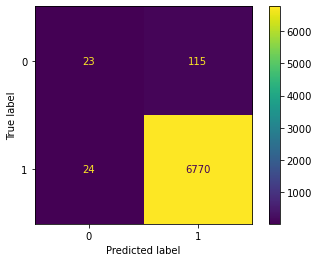

In [23]:
plot_confusion_matrix(naive_model,X_test_mat, Y_test, cmap = "viridis");

#### Comments:
The accuracy, precision and recall scores appear to be good, but the confusion matrix tells us something devastating. Out of 138 true negatives, only 23 were true negatives !! <br>
This observation is because of the **extreme** imbalance in the dataset.
##### Let's see the scores for a blind estimator that always classifies as positive

In [24]:
print("Accuracy Blind:", accuracy_score(Y_test, np.ones_like(preds)))
print("Precision Blind:", precision_score(Y_test, np.ones_like(preds)))
print("Recall Blind:", recall_score(Y_test, np.ones_like(preds)))

Accuracy Blind: 0.9800923254472014
Precision Blind: 0.9800923254472014
Recall Blind: 1.0


As we can see, the data is **so unbalanced, that a blind estimator can yield results that appear tempting**<br>
Let's check another metric, the **balanced accuracy**

In [25]:
balanced_accuracy_score(Y_test, preds)

0.5815670689824355

So, the balanced accuracy score is very poor, where it gets the performance averaged over classes

#### To counter this, we can try training the classifier on  a sampled, balanced version of the data

## Model 2: Balanced Data
This can be done by 
* Separating the positive and negative ratings into 2 dataframes
* Choose like 80% of the negative reviews, as training data `(X1,Y1)`. The other 20% are testing data `(X1T, Y1T)`
* From the positive reviews choose an equal number of rows for the training data `(X2, Y2)`. The rest are added to the testing data `(X2T, Y2T)`
* This way, our training dataset is balanced `(X1 + X2, Y1 + Y2)`, where the plus here means concatenating

In [26]:
neg = df[df.rating == 0]
pos = df[df.rating == 1]

# split the negative rating into training and test
X1, X1T, Y1, Y1T = train_test_split(neg.text, neg.rating, test_size = 0.2)
# X2 is only positive rating, as big as X1
X2, X2T, Y2, Y2T = train_test_split(pos.text, pos.rating, train_size = len(X1)/len(pos))
# Concatenating for training and test sets
X_train2 = pd.concat([X1, X2])
X_test2 = pd.concat([X1T, X2T])
Y_train2 = pd.concat([Y1, Y2])
Y_test2 = pd.concat([Y1T, Y2T])

### Model building and testing

In [27]:
# Bag of words
vectorizer2 = CountVectorizer(token_pattern=r"\b[^\d\W]{3,}\b") 
X_train_mat2 = vectorizer2.fit_transform(X_train2)

# Naive model
naive_model2 = MultinomialNB()
naive_model2.fit(X_train_mat2, Y_train2)
X_test_mat2 = vectorizer2.transform(X_test2)

# performance over test data
preds2 = naive_model2.predict(X_test_mat2)
print("Accuracy, balanced:", accuracy_score(Y_test2, preds2))
print("balanced accuracy:", balanced_accuracy_score(Y_test2, preds2))
print("Precision, balanced:", precision_score(Y_test2, preds2))
print("Recall, balanced:", recall_score(Y_test2, preds2))

Accuracy, balanced: 0.8224273852702257
balanced accuracy: 0.8527817109242666
Precision, balanced: 0.9993043350908026
Recall, balanced: 0.8221278390264474


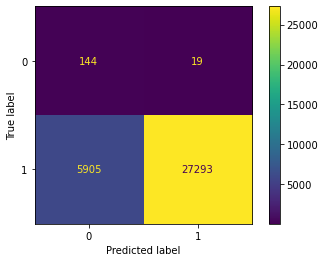

In [28]:
plot_confusion_matrix(naive_model2,X_test_mat2, Y_test2);

#### From the scores and the confusion matrix:
* We sacrificed some true positives. On the other hand, the majority of negative data are classified correctly.

#### Generally:
* I believe this is Ok for a baseline model, however, there are several improvements that can be done
>* Handle negation, by appending NOT to the sentence, until the last delimiter. This can improve results
>* Tokenize based on POS tag, or select only adjectives, adverbs and verbs in the bag of words
* I also tried the `binary` keyword for binarized features. There was no significant differnce in performance

## Iteration 3: Only select adjectives, verbs and adverbs
Using nltk, we can filter the text based on POS_tag. This should make the classifier more focused on relevant, and focus less on noisy words

In [34]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [35]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [41]:
relevant_tags = set(["JJ", "JJR", "JJS", # adjectives
                 "RB", "RBR", "RBS",  # adverbs
                 "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]) # verbs

def transform_text(text):
    transformed_string = ""
    # convert to lower case
    text = text.lower()
    # tokenize
    tokens = nltk.word_tokenize(text)
    # get pos_tags
    pos_tags = nltk.pos_tag(tokens)
    
    # get the words with relevant tags
    for token, tag in pos_tags:
        # chekc if the word exists in the English language (exclude typos)
        if len(wordnet.synsets(token)) == 0:
            continue
        if tag in relevant_tags:
            lemmatized = wordnet_lemmatizer.lemmatize(token, get_wordnet_pos(tag))
            transformed_string += lemmatized 
        else:
            continue
        transformed_string += " "
    
    return transformed_string

In [42]:
df_trans = df.copy()
df_trans.text = df_trans.text.map(transform_text)
df_trans.text = df_trans.text.str.lower()

In [43]:
df_trans.text

0        so far have not disappoint love use i monitor ...
1                              great experienced buy love 
2        inexpensive use learn step up be thrill learn ...
3        have now i love be great be prime be shin i lo...
4        buy grand come visit set enter now amazon make...
                               ...                        
34654    be not appreciably faster other high use kindl...
34655    include charge extra be include be use instead...
34656    love kindle i be really disappoint kindle fast...
34657    be surprise find do not come charge so i have ...
34658    spite have good say ever get i love i find gre...
Name: text, Length: 34659, dtype: object

In [44]:
Y3 = df_trans.rating
X3 = df_trans.text
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, Y3, test_size = 0.2, random_state = 0)

In [45]:
vectorizer3 = CountVectorizer(token_pattern=r"\b[^\d\W]{3,}\b") 
X_train_mat3 = vectorizer3.fit_transform(X_train3)
vectorizer3.get_feature_names()[:20]

['aaa',
 'abandon',
 'abc',
 'able',
 'abnormal',
 'abound',
 'about',
 'above',
 'abroad',
 'abruptly',
 'absolute',
 'absolutely',
 'absorb',
 'abundant',
 'abuse',
 'accept',
 'acceptable',
 'acceptably',
 'access',
 'accessible']

In [46]:
neg3 = df_trans[df_trans.rating == 0]
pos3 = df_trans[df_trans.rating == 1]

# split the negative rating into training and test
X13, X1T3, Y13, Y1T3 = train_test_split(neg3.text, neg3.rating, test_size = 0.2)
# X2 is only positive rating, as big as X1
X23, X2T3, Y23, Y2T3 = train_test_split(pos3.text, pos3.rating, train_size = len(X13)/len(pos3))
# Concatenating for training and test sets
X_train3 = pd.concat([X13, X23])
X_test3 = pd.concat([X1T3, X2T3])
Y_train3 = pd.concat([Y13, Y23])
Y_test3 = pd.concat([Y1T3, Y2T3])

In [47]:
# Bag of words
vectorizer3 = CountVectorizer(token_pattern=r"\b[^\d\W]{3,}\b") 
X_train_mat3 = vectorizer3.fit_transform(X_train3)

# Naive model
naive_model3 = MultinomialNB()
naive_model3.fit(X_train_mat3, Y_train3)
X_test_mat3 = vectorizer3.transform(X_test3)

# performance over test data
preds3 = naive_model3.predict(X_test_mat3)
print("Accuracy, balanced:", accuracy_score(Y_test3, preds3))
print("balanced accuracy:", balanced_accuracy_score(Y_test3, preds3))
print("Precision, balanced:", precision_score(Y_test3, preds3))
print("Recall, balanced:", recall_score(Y_test3, preds3))

Accuracy, balanced: 0.812475645214472
balanced accuracy: 0.8080999040152097
Precision, balanced: 0.9988150781307857
Recall, balanced: 0.8125188264353275


In [48]:
X_test_mat3 = vectorizer3.transform(X_test3)

In [49]:
preds3 = naive_model3.predict(X_test_mat3)

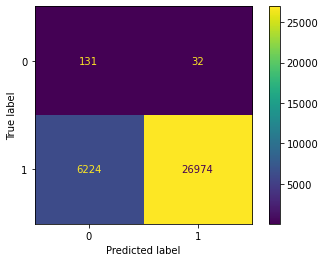

In [50]:
plot_confusion_matrix(naive_model3,X_test_mat3, Y_test3, cmap = "viridis");